In [7]:
import torch
import cv2
import matplotlib.pyplot as plt
from segment_anything.build_sam import build_siamese_sam
from segment_anything.dataloader import MedicalDataset
from segment_anything.utils import ContrasiveStructureLoss, LaplacianPyramid
from torchvision.transforms import transforms

In [8]:
sliceimg = 9
num_classes = 3
device = 'cuda'

In [9]:
test_CT = []
test_MRI = []

9
(256, 256)


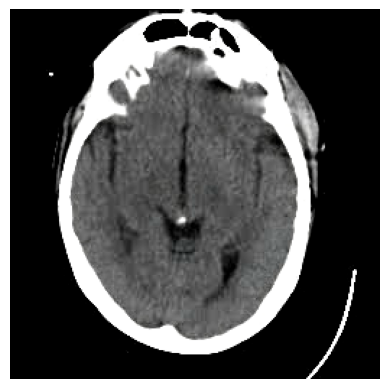

In [10]:
cap = cv2.VideoCapture('./dataset/Neoplastic_Disease/Metastatic_2/CT/spatial.mpg')
n = 0
while cap.isOpened():
    ret, frame = cap.read()
    n += 1
    if not ret or n == sliceimg:
        break
print(n)
CT = cap.read()[1]
plt.imshow(CT)
plt.axis('off')
CT = cv2.cvtColor(CT, cv2.COLOR_BGR2GRAY)
print(CT.shape)

9
(256, 256)


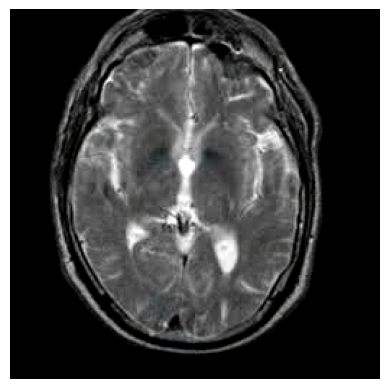

In [11]:
cap = cv2.VideoCapture('./dataset/Neoplastic_Disease/Metastatic_2/MR-T2/spatial (1).mpg')
n = 0
while cap.isOpened():
    ret, frame = cap.read()
    n += 1
    if not ret or n == sliceimg:
        break
print(n)
MRI = cap.read()[1]
plt.imshow(MRI)
plt.axis('off')
MRI = cv2.cvtColor(MRI, cv2.COLOR_BGR2GRAY)
print(MRI.shape)

(256, 256) (256, 256)


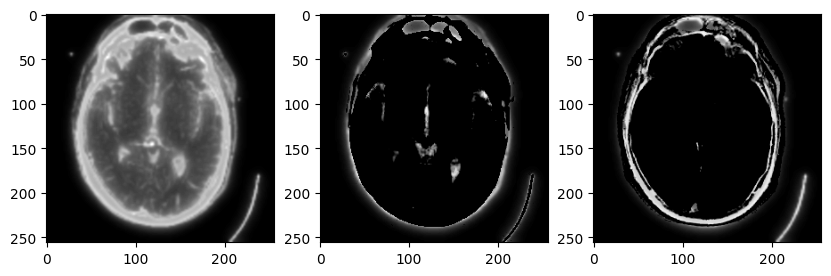

In [12]:
import cv2
import numpy as np

def build_laplacian_pyramid(image, levels):
    target_size = (256, 256)
    gaussian_pyramid = [image]
    for i in range(levels - 1):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)
    
    laplacian_pyramid = [gaussian_pyramid[levels - 1]]
    for i in range(levels - 1, 0, -1):
        expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], expanded)
        laplacian_pyramid.append(laplacian)
        # print(cv2.resize(laplacian, target_size).shape)
    
    return laplacian_pyramid

def blend_images(image1, image2, levels):
    target_size = (256, 256)
    laplacian_pyramid1 = build_laplacian_pyramid(image1, levels)
    laplacian_pyramid2 = build_laplacian_pyramid(image2, levels)
    
    blended_pyramid = []
    for lap1, lap2 in zip(laplacian_pyramid1, laplacian_pyramid2):
        blended = np.where(np.abs(lap1) > np.abs(lap2), lap1, lap2)
        blended_pyramid.append(blended)
    
    blended_image = blended_pyramid[0]
    for i in range(1, levels - 1):
        blended_image = cv2.pyrUp(blended_image)
        blended_image = cv2.add(blended_pyramid[i], blended_image) // 2

    return blended_image
# 指定金字塔的级别数量
levels = 4

# 图像融合
blended_image = blend_images(CT, MRI, levels)
blended_image = cv2.pyrUp(blended_image)
print(blended_image.shape, CT.shape)
diff_CT = cv2.subtract(blended_image, CT)
diff_MRI = cv2.subtract(blended_image, MRI)


plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(blended_image, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(diff_CT, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(diff_MRI, cmap='gray')

plt.show()
# 显示融合后的图像

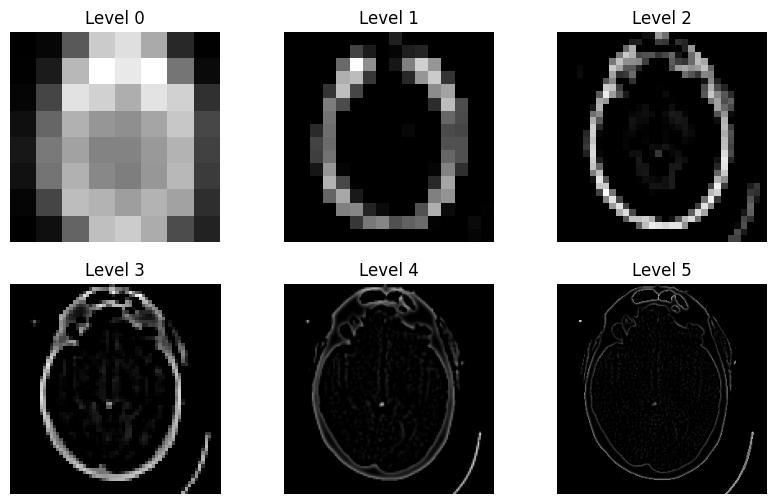

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_laplacian_pyramid(image, levels):
    # 构建高斯金字塔
    gaussian_pyramid = [image]
    for i in range(levels - 1):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)
    
    # 构建拉普拉斯金字塔
    laplacian_pyramid = [gaussian_pyramid[levels - 1]]
    for i in range(levels - 1, 0, -1):
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    
    return laplacian_pyramid

# 构建高斯-拉普拉斯金字塔
levels = 6
pyramid = gaussian_laplacian_pyramid(CT, levels)

# 创建subplot并显示金字塔中的图像
plt.figure(figsize=(10, 6))
for i in range(levels):
    plt.subplot(2, levels // 2, i + 1)
    plt.imshow(pyramid[i], cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

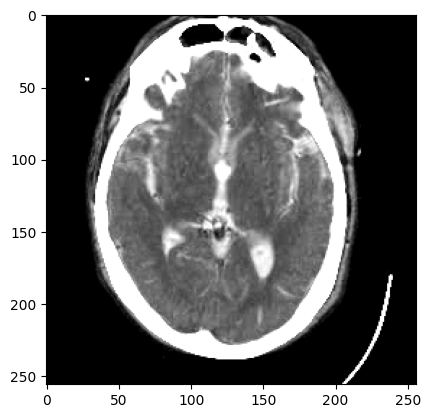

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 确保两幅图像大小相同
MRI = cv2.resize(MRI, (CT.shape[1], CT.shape[0]))

# 求两幅图像的最大值
new_img = np.maximum(CT, MRI)

# 显示融合后的图像
plt.imshow(new_img, cmap='gray')
plt.show()


In [15]:
print(MRI.shape)

(256, 256)


In [16]:
PATH = 'model/SiameseSAM_epoch400.pth'
SiameseSAM = build_siamese_sam(num_classes=num_classes, checkpoint=PATH).to(device)
SiameseSAM.eval()
laplacian_pyramid = LaplacianPyramid(levels=4, device='cuda')

In [17]:
from thop import profile
inputs1 = torch.randn(1, 1, 256, 256).to(device)
inputs2 = torch.randn(1, 1, 256, 256).to(device)

# 计算FLOPs和参数量
flops, params = profile(SiameseSAM, inputs=([[inputs1, inputs2]]))
print(f'FLOPs: {flops}')
print(f'Number of parameters: {params}')

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
FLOPs: 64147022604.0
Number of parameters: 223918535.0


In [18]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256))
        ])
inputs = [transform(CT), transform(MRI)]
inputs = [i.to(device).unsqueeze(0) for i in inputs]
laplacian_CT, laplacian_MRI = laplacian_pyramid.build_laplacian_pyramid_CT(inputs[0]), laplacian_pyramid.build_laplacian_pyramid_MRI(inputs[1])
inputs = [laplacian_CT[0], laplacian_MRI[0]]

/home/hansenfeng/anaconda3/envs/sam/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [19]:
output = SiameseSAM(inputs)
output[4] = laplacian_pyramid(output[4])

In [20]:
img = output[4][0].squeeze(0)

In [21]:
print(img[120][170])

tensor(1.3066, device='cuda:0', grad_fn=<SelectBackward0>)


(-0.5, 255.5, 255.5, -0.5)

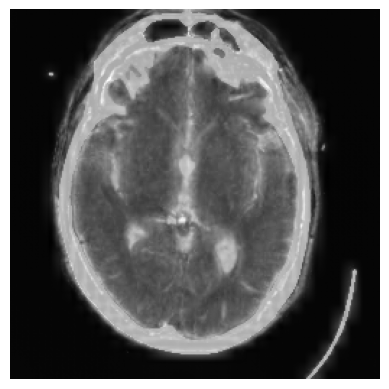

In [22]:
plt.imshow(img.detach().cpu(), cmap='gray')
plt.axis('off')

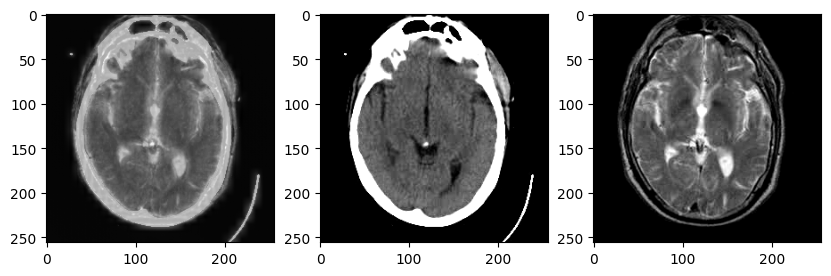

In [23]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(img.detach().cpu(), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(CT, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(MRI, cmap='gray')

In [24]:
SSAM_output = []
for C, M, in zip(test_CT, test_MRI):
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((256, 256))
            ])
    inputs = [transform(CT), transform(MRI)]
    inputs = [i.to(device).unsqueeze(0) for i in inputs]
    laplacian_CT, laplacian_MRI = laplacian_pyramid.build_laplacian_pyramid_CT(inputs[0]), laplacian_pyramid.build_laplacian_pyramid_MRI(inputs[1])
    inputs = [laplacian_CT[0], laplacian_MRI[0]]
    output = SiameseSAM(inputs)
    output[4] = laplacian_pyramid(output[4])
    img = output[4][0].squeeze(0).cpu().detach().numpy()
    SSAM_output.append(img)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd6993e72b0>>
Traceback (most recent call last):
  File "/home/hansenfeng/anaconda3/envs/sam/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


IndexError: list index out of range

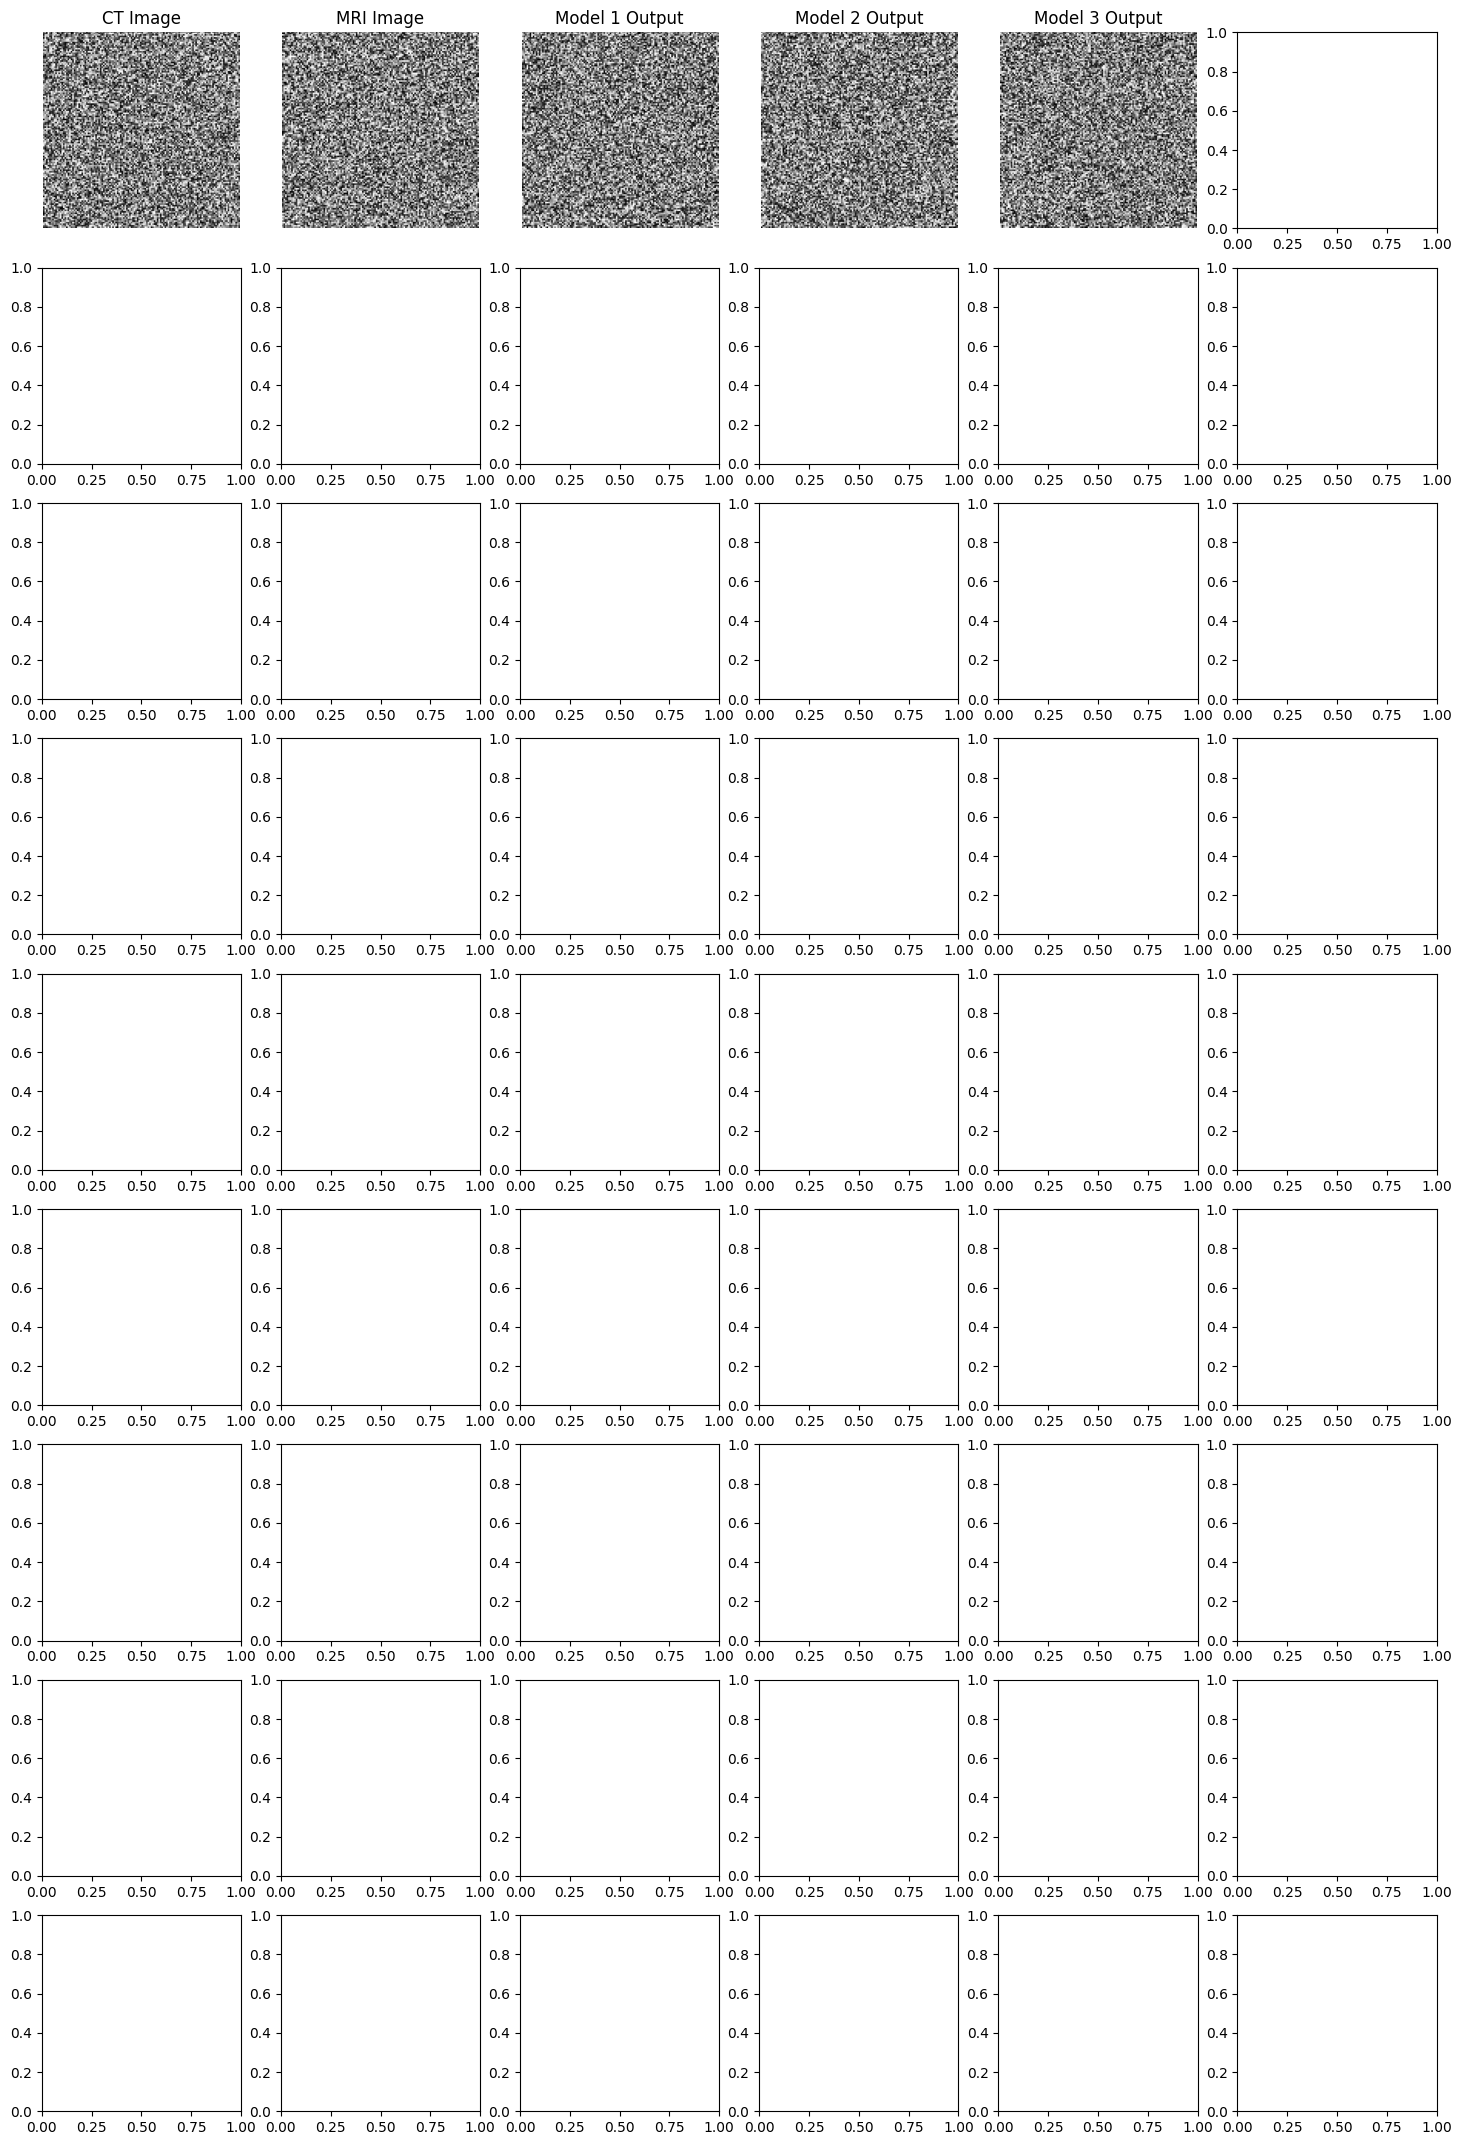

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据生成函数
def generate_image(shape=(128, 128)):
    return np.random.rand(*shape)

# 假设你有9个病例的原始CT和MRI影像以及四个模型的输出
num_slices = 9
ct_images = [generate_image() for _ in range(num_slices)]
mri_images = [generate_image() for _ in range(num_slices)]
model1_outputs = [generate_image() for _ in range(num_slices)]
model2_outputs = [generate_image() for _ in range(num_slices)]
model3_outputs = [generate_image() for _ in range(num_slices)]
model4_outputs = [generate_image() for _ in range(num_slices)]

# 创建一个3x5的网格
fig, axes = plt.subplots(num_slices, 6, figsize=(18, num_slices * 3))

# 绘制图像
for i in range(num_slices):
    # 绘制CT图像
    axes[i, 0].imshow(ct_images[i], cmap='gray')
    axes[i, 0].set_title('CT Image')
    axes[i, 0].axis('off')

    # 绘制MRI图像
    axes[i, 1].imshow(mri_images[i], cmap='gray')
    axes[i, 1].set_title('MRI Image')
    axes[i, 1].axis('off')

    # 绘制模型1的输出
    axes[i, 2].imshow(model1_outputs[i], cmap='gray')
    axes[i, 2].set_title('Model 1 Output')
    axes[i, 2].axis('off')

    # 绘制模型2的输出
    axes[i, 3].imshow(model2_outputs[i], cmap='gray')
    axes[i, 3].set_title('Model 2 Output')
    axes[i, 3].axis('off')

    # 绘制模型3的输出
    axes[i, 4].imshow(model3_outputs[i], cmap='gray')
    axes[i, 4].set_title('Model 3 Output')
    axes[i, 4].axis('off')

    # 绘制模型4的输出
    axes[i, 5].imshow(SSAM_output[i], cmap='gray')
    axes[i, 5].set_title('SSAM Output')
    axes[i, 5].axis('off')

# 调整布局
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

# 定义 SSIM 损失函数
def ssim_loss(img1, img2, window_size=11, size_average=True):
    # 计算均值和方差
    mu1 = F.avg_pool2d(img1, window_size, stride=1, padding=0)
    mu2 = F.avg_pool2d(img2, window_size, stride=1, padding=0)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    # 计算方差
    sigma1_sq = F.avg_pool2d(img1 ** 2, window_size, stride=1, padding=0) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 ** 2, window_size, stride=1, padding=0) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, window_size, stride=1, padding=0) - mu1_mu2

    # 计算 SSIM
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return torch.mean(ssim_map)
    else:
        return ssim_map


loss = ssim_loss(torch.tensor(MRI).unsqueeze(0).float(), img.unsqueeze(0).float().cpu())
print(f"SSIM Loss: {loss.item()}")


SSIM Loss: 0.5080950260162354


In [ ]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import rank
from skimage.morphology import disk
from scipy.stats import entropy
from sewar.full_ref import vifp


def map_tensor_to_0_255(input_tensor):
    # 找到最小值和最大值
    min_val = torch.min(input_tensor)
    max_val = torch.max(input_tensor)
    
    # 归一化到 [0, 1]
    normalized_tensor = (input_tensor - min_val) / (max_val - min_val)
    
    # 映射到 [0, 255]
    mapped_tensor = normalized_tensor * 255.0
    
    # 将结果转换为 uint8 类型
    mapped_tensor = mapped_tensor.type(torch.uint8)
    
    return mapped_tensor


def calculate_entropy(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    hist, _ = np.histogram(image, bins=256, range=(0, 255), density=True)
    return entropy(hist)


def calculate_standard_deviation(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    image = np.array(image)
    return np.std(image)


def calculate_spatial_frequency(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    M, N = image.shape
    RF = np.sqrt(np.sum(np.diff(image, axis=0)**2) / (M * N))
    CF = np.sqrt(np.sum(np.diff(image, axis=1)**2) / (M * N))
    return np.sqrt(RF**2 + CF**2)


def calculate_average_gradient(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    gx, gy = np.gradient(image)
    return np.mean(np.sqrt(gx**2 + gy**2))


def calculate_scd(image1, image2):
    if len(image1.shape) == 3:
        image1 = rgb2gray(image1)
    if len(image2.shape) == 3:
        image2 = rgb2gray(image2)
    scd = np.sum((image1 - image2)**2) / np.sum(image1**2)
    return scd


def calculate_vif(image1, image2):
    if len(image1.shape) == 3:
        image1 = rgb2gray(image1)
    if len(image2.shape) == 3:
        image2 = rgb2gray(image2)
    return vifp(image1, image2)

# 示例用法
image = map_tensor_to_0_255(img.detach().cpu()).float()
en = calculate_entropy(image)
print("Entropy:", en)

sd = calculate_standard_deviation(image)
print("Standard Deviation:", sd)

sf = calculate_spatial_frequency(image)
print("Spatial Frequency:", sf)

ag = calculate_average_gradient(image)
print("Average Gradient:", ag)

scd = calculate_scd(image.numpy(), CT.astype(np.float32))
print("Structure Content Dissimilarity:", scd)

vif = calculate_vif(image.numpy(), CT.astype(np.float32))
print("Visual Information Fidelity:", vif)

Entropy: 3.756891910937808
Standard Deviation: 69.025185
Spatial Frequency: 15.50773181654074
Average Gradient: 5.9432087
Structure Content Dissimilarity: 0.19403824
Visual Information Fidelity: 0.2506567863396307
